In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf


/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


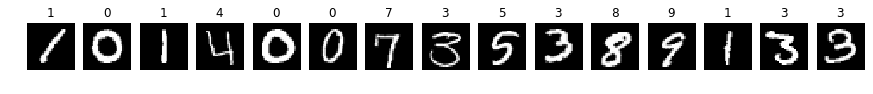

In [3]:
Y = df_train['label']
X = df_train.drop('label', axis=1)
X = X.apply(lambda x: x*2.0/255.0 - 1.0)
fig1, ax1 = plt.subplots(1,15, figsize=(15,10))
for i in range(15):
    ax1[i].imshow(X.iloc[i].values.reshape((28,28)), cmap='gray')
    ax1[i].axis('off')
    ax1[i].set_title(Y[i])

In [5]:
x = tf.placeholder(tf.float32, [None, 784])
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))
y = tf.matmul(x, W) + b
y_ = tf.placeholder(tf.float32, [None, 10])
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [6]:
def get_batch(BATCH_SIZE=64):
    while (1):
        for i in range(0, len(X), BATCH_SIZE):
            x_train, y_train = X[i:i+BATCH_SIZE], Y[i:i+BATCH_SIZE]
            yield (x_train, y_train)
            
gen = get_batch(64)
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()
for i in range(500):
    batch_xs, batch_ys = next(gen)
    batch_ys = np.eye(10)[batch_ys]
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

    correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    if i%50 == 0:
        print('ACCURACY:', sess.run(accuracy, feed_dict={x: batch_xs, y_: batch_ys}))

ACCURACY: 0.1875
ACCURACY: 0.75
ACCURACY: 0.875
ACCURACY: 0.921875
ACCURACY: 0.890625
ACCURACY: 0.890625
ACCURACY: 0.90625
ACCURACY: 0.859375
ACCURACY: 0.84375
ACCURACY: 0.90625


Text(0.5, 1.0, 'True')

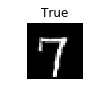

In [7]:
grad = tf.gradients(cross_entropy, x)
signed_grad = tf.sign(grad)
scaled_signed_grad = 0.8 * signed_grad
adv_x = (((tf.clip_by_value((x + scaled_signed_grad), -1, 1)+ 1.0) * 0.5) * 255.0)
fig, ax = plt.subplots(1,1, figsize=(1,10))
ax.imshow(X.iloc[6].values.reshape((28,28)), cmap='gray')
ax.axis('off')
ax.set_title("True")

Text(0.5, 1.0, 'Fake')

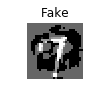

In [8]:
one_hot_output = np.eye(10)[Y[6]].reshape(1,10)
advsarial_out = sess.run(adv_x, feed_dict={x: X.iloc[6].values.reshape(1,784), y_:one_hot_output})
fig, ax = plt.subplots(1,1, figsize=(1,10))
ax.imshow(advsarial_out.reshape((28,28)).reshape((28,28)), cmap='gray')
ax.axis('off')
ax.set_title("Fake")

In [19]:
for i in range(10):
    print()
    one_hot_output = np.eye(10)[Y[i]].reshape(1,10)
    advsarial_out = sess.run(adv_x, feed_dict={x: X.iloc[i].values.reshape(1,784), y_:one_hot_output})
    original_prediction = sess.run(y, feed_dict={x: X.iloc[i].values.reshape(1,784), y_:one_hot_output})
    print('Original Prediction',np.argmax(original_prediction, 1))
    adversarial_prediction = sess.run(y, feed_dict={x: advsarial_out.reshape(1,784), y_:one_hot_output})
    print('Fake Prediction', np.argmax(adversarial_prediction, 1))

Original Prediction [1]
Fake Prediction [2]
Original Prediction [0]
Fake Prediction [2]
Original Prediction [1]
Fake Prediction [8]
Original Prediction [2]
Fake Prediction [2]
Original Prediction [0]
Fake Prediction [2]
Original Prediction [0]
Fake Prediction [2]
Original Prediction [7]
Fake Prediction [9]
Original Prediction [3]
Fake Prediction [9]
Original Prediction [5]
Fake Prediction [8]
Original Prediction [3]
Fake Prediction [2]
